In [1]:
import glob
import skimage.io as io
import numpy as np
#import commonfunctions as cf
import sklearn
from skimage.feature import hog
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn import svm
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import pickle
import cv2
import random
import os

from PIL import Image, ImageEnhance



from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
import numpy as np


import argparse
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import *
from sklearn.decomposition import PCA




/home/mohamed/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
'''
if you want to load the data again to work with them
'''

male_data=np.load('male_data.npy',allow_pickle=True)
female_data=np.load('female_data.npy',allow_pickle=True)

EOFError: Ran out of input

(232, 1420, 1000)
(1420, 1000)


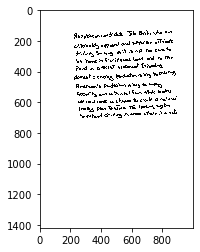

In [ ]:
print(male_data.shape)
print(female_data[0].shape)
plt.imshow(male_data[0],cmap='gray')

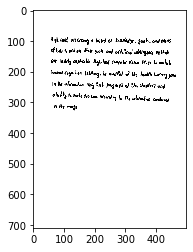

In [4]:

for i,img in enumerate(male_data):
    k=5
    wshape=(100*k,142*k)

    temp=cv2.resize(img,wshape)
    plt.imshow(temp,cmap='gray')
    if(i==2):
        break

In [ ]:
# for i,img in enumerate(female_data):
#     k=5
#     wshape=(100*k,142*k)

#     female_data[i]=cv2.resize(img,wshape)

True

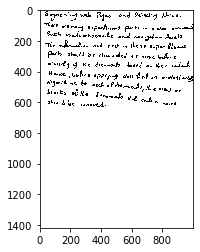

In [ ]:
plt.imshow(male_data[0],cmap='gray')
cv2.imwrite("lol.jpg",male_data[0])

In [ ]:


N_ANGLE_BINS = 40
BIN_SIZE = 360 // N_ANGLE_BINS
LEG_LENGTH = 25

def get_contour_pixels(bw_image):
    contours, _= cv2.findContours(
        bw_image, cv2.RETR_TREE, 
        cv2.CHAIN_APPROX_NONE
        ) 
    # contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
    
    img2 = bw_image.copy()[:,:,np.newaxis]
    img2 = np.concatenate([img2, img2, img2], axis = 2)
    
    # if self.show_images:
    #     for cnt in contours : 
    #         cv2.drawContours(img2, [cnt], 0, (255, 0, 0), 1)  
            
    #     plt.imshow(img2, cmap='gray')
    return contours

def get_hinge_features(bw_image):
    # if self.is_binary:
    #     bw_image, _ = self.preprocess_binary_image(img_file, self.sharpness_factor, self.bordersize)
    # else:
    #     bw_image, _ = self.preprocess_image(img_file, self.sharpness_factor, self.bordersize)
    
    contours = get_contour_pixels(bw_image)
    
    hist = np.zeros((N_ANGLE_BINS, N_ANGLE_BINS))
        
    # print([len(cnt) for cnt in contours])
    for cnt in contours:
        n_pixels = len(cnt)
        if n_pixels <= LEG_LENGTH:
            continue
        
        points = np.array([point[0] for point in cnt])
        xs, ys = points[:, 0], points[:, 1]
        point_1s = np.array([cnt[(i + LEG_LENGTH) % n_pixels][0] for i in range(n_pixels)])
        point_2s = np.array([cnt[(i - LEG_LENGTH) % n_pixels][0] for i in range(n_pixels)])
        x1s, y1s = point_1s[:, 0], point_1s[:, 1]
        x2s, y2s = point_2s[:, 0], point_2s[:, 1]
        
        phi_1s = np.degrees(np.arctan2(y1s - ys, x1s - xs) + np.pi)
        phi_2s = np.degrees(np.arctan2(y2s - ys, x2s - xs) + np.pi)
        
        indices = np.where(phi_2s > phi_1s)[0]
        
        for i in indices:
            phi1 = int(phi_1s[i] // BIN_SIZE) % N_ANGLE_BINS
            phi2 = int(phi_2s[i] // BIN_SIZE) % N_ANGLE_BINS
            hist[phi1, phi2] += 1
            
    normalised_hist = hist / np.sum(hist)
    feature_vector = normalised_hist[np.triu_indices_from(normalised_hist, k = 1)]
    
    return feature_vector

    

In [8]:


hinge_male=[]
hinge_female=[]

for i,img in enumerate(male_data):
    try:
        hinge_male.append(get_hinge_features(img))
    except :
        print(i)

# for i,img in enumerate(female_data):
#     try:
#         hinge_female.append(get_hinge_features(img))
#     except:
#         print(i)

hinge_male=np.array(hinge_male)
# hinge_female=np.array(hinge_female)

In [9]:

X=np.concatenate((hinge_male,hinge_female),axis=0)

Y=np.concatenate((np.ones(hinge_male.shape[0]),
                np.zeros(hinge_female.shape[0])),
                axis=0)

In [10]:
pca=PCA(n_components=40)
X=pca.fit_transform(X)
print(hinge_male[0].shape)
print(X.shape, Y.shape)


(780,)
(363, 40) (363,)


In [11]:
X,Y=sklearn.utils.shuffle(X,Y)

In [12]:
# X_train=X[:200]
# Y_train=Y[:200]

# X_test=X[200:]
# Y_test=Y[200:]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=109) # 70% training and 30% test


In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(290, 40) (73, 40) (290,) (73,)


In [14]:
clf = svm.SVC(kernel='rbf', verbose=True, C=10)

clf.fit(X_train, y_train)


[LibSVM]..*.*
optimization finished, #iter = 922
obj = -336.681373, rho = 0.574788
nSV = 177, nBSV = 10
Total nSV = 177


SVC(C=10, verbose=True)

In [15]:

y_pred = clf.predict(X_test)

In [16]:

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.821917808219178


In [17]:

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.8297872340425532
Recall: 0.8863636363636364


In [3]:
lol=np.ones(100)

In [4]:
lol=np.reshape(lol,(100,1))

In [5]:
print(lol.shape)

(100, 1)


In [6]:
print(lol)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
